<a href="https://colab.research.google.com/github/MRsources/MRzero-Core/blob/main/documentation/playground_mr0/mr0_FLASH_2D_seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pypulseq &> /dev/null
!pip install  torchkbnufft --no-deps
!pip install MRzeroCore --no-deps
!pip install pydisseqt

!wget https://github.com/MRsources/MRzero-Core/raw/main/documentation/playground_mr0/numerical_brain_cropped.mat &> /dev/null

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 406.9/406.9 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 470.5/470.5 kB 7.3 MB/s eta 0:00:00


(FLASH_2D_seq)=
# 2D FLASH

<ipython-input-16-f240779d18db>:29: UserWarning: Specified RF delay 0.00 us is less than the dead time 100 us. Delay was increased to the dead time.
  rf1, _, _ = pp.make_sinc_pulse(
<ipython-input-16-f240779d18db>:38: UserWarning: Specified ADC delay 10.00 us is less than the dead time 20 us. Delay was increased to the dead time.
  adc = pp.make_adc(num_samples=Nread, duration=Nread*dwell_time, phase_offset=0 * np.pi/180, delay=gx.rise_time, system=system)


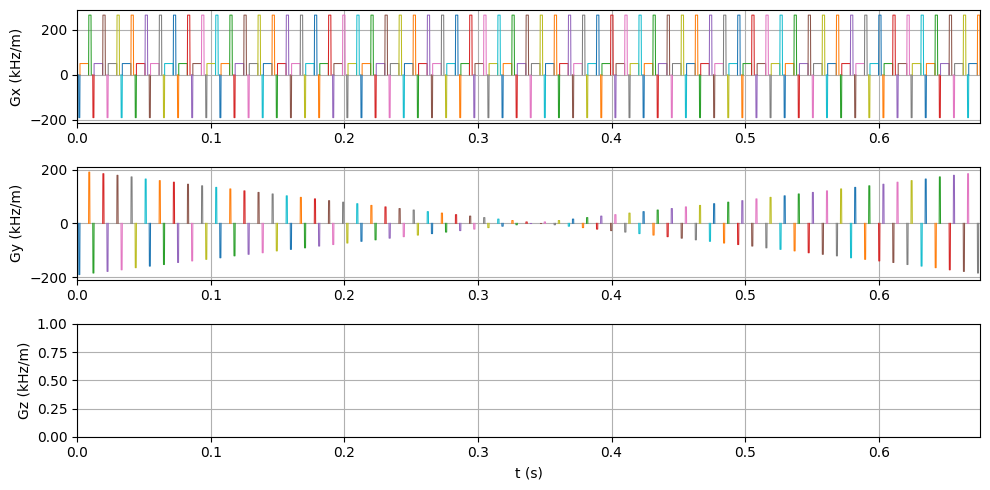

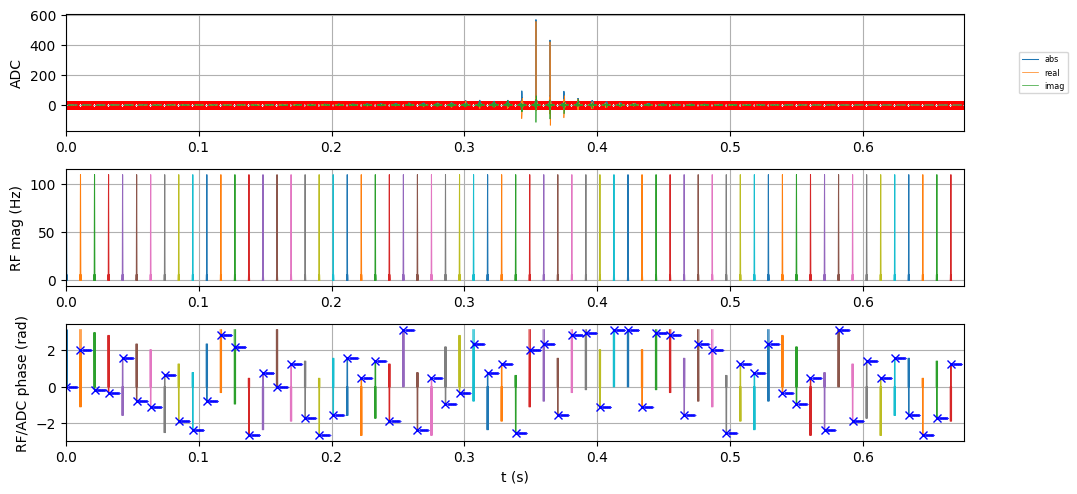

zoom into one TR


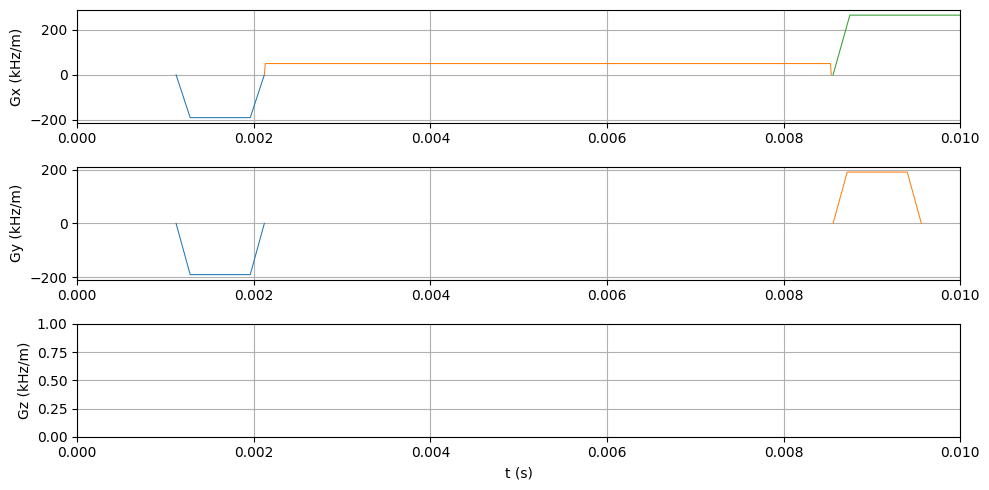

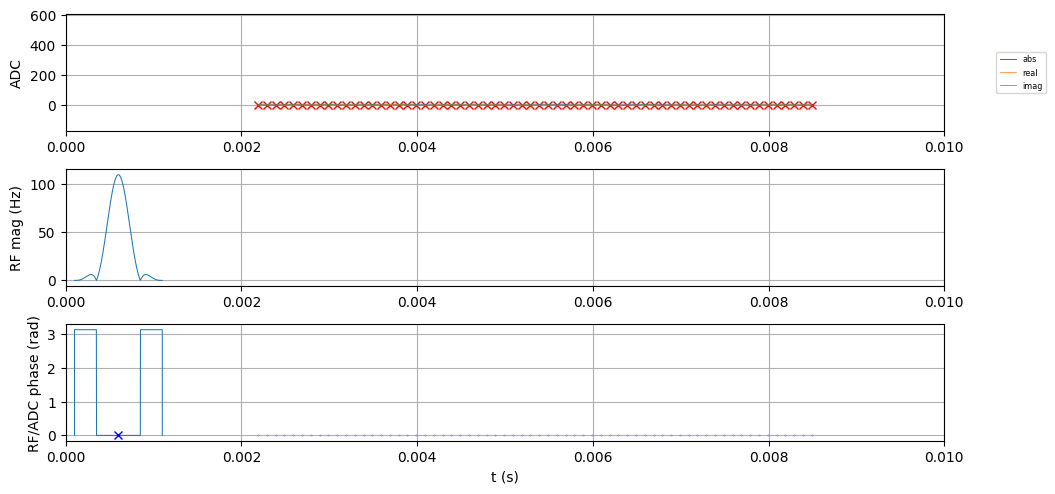

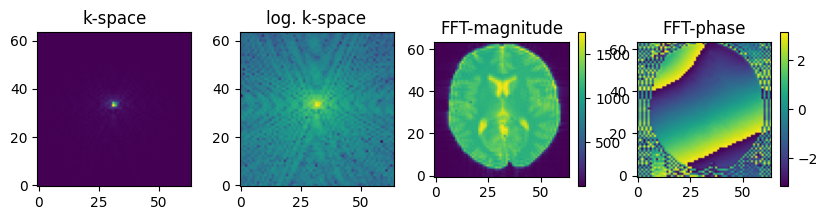

In [16]:
import numpy as np
import MRzeroCore as mr0
import pypulseq as pp
import torch
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

experiment_id = 'FLASH_2D'

# %% S1. SETUP sys

# choose the scanner limits
system = pp.Opts(max_grad=28,grad_unit='mT/m',max_slew=150,slew_unit='T/m/s',
                 rf_ringdown_time=20e-6,rf_dead_time=100e-6,adc_dead_time=20e-6,grad_raster_time=10e-6)

# %% S2. DEFINE the sequence
seq = pp.Sequence()

# Define FOV and resolution
fov = 200e-3
slice_thickness = 8e-3
Nread = 64    # frequency encoding steps/samples
Nphase = 64    # phase encoding steps/samples
dwell_time = 10e-5

# Define rf events
rf1, _, _ = pp.make_sinc_pulse(
    flip_angle=10 * np.pi / 180, duration=1e-3,
    slice_thickness=slice_thickness, apodization=0.5, time_bw_product=4,
    system=system, return_gz=True
)
# rf1 = pp.make_block_pulse(flip_angle=90 * np.pi / 180, duration=1e-3, system=system)

# Define other gradients and ADC events
gx = pp.make_trapezoid(channel='x', flat_area=Nread / fov, flat_time=Nread*dwell_time, system=system)
adc = pp.make_adc(num_samples=Nread, duration=Nread*dwell_time, phase_offset=0 * np.pi/180, delay=gx.rise_time, system=system)
gx_pre = pp.make_trapezoid(channel='x', area=-gx.area / 2, duration=1e-3, system=system)
gx_spoil = pp.make_trapezoid(channel='x', area=1.5 * gx.area, duration=2e-3, system=system)

rf_phase = 0
rf_inc = 0
rf_spoiling_inc = 117

# ======
# CONSTRUCT SEQUENCE
# ======
##linear reordering
phenc = np.arange(-Nphase // 2, Nphase // 2, 1) / fov
permvec =np.arange(0, Nphase, 1)
## centric reordering
#permvec = sorted(np.arange(len(phenc)), key=lambda x: abs(len(phenc) // 2 - x))
## random reordering
#perm =np.arange(0, Nphase, 1);  permvec = np.random.permutation(perm)

phenc_centr = phenc[permvec]

for ii in range(0, Nphase):  # e.g. -64:63
    rf1.phase_offset = rf_phase / 180 * np.pi   # set current rf phase
    adc.phase_offset = rf_phase / 180 * np.pi  # follow with ADC
    rf_inc = divmod(rf_inc + rf_spoiling_inc, 360.0)[1]   # increase increment
    # increment additional phase
    rf_phase = divmod(rf_phase + rf_inc, 360.0)[1]
    seq.add_block(rf1)
    gp = pp.make_trapezoid(channel='y', area=phenc_centr[ii], duration=1e-3, system=system)
    seq.add_block(gx_pre, gp)
    seq.add_block(adc, gx)
    gp = pp.make_trapezoid(channel='y', area=-phenc_centr[ii], duration=1e-3, system=system)
    seq.add_block(gx_spoil, gp)


#quick 2D brain phantom sim with small changes
obj=mr0.util.load_phantom([128,128],B0_polynomial=(0,0,-150,1,1,0))  # will download the standard brain phantom and augment it with B0 inhom.
signal, ktraj_adc = mr0.util.simulate(seq,obj,accuracy=1e-5)


seq.plot(plot_now=False)
mr0.util.insert_signal_plot(seq=seq, signal =signal.numpy())
plt.show()

#zoom into one TR
print('zoom into one TR')
seq.plot(plot_now=False,time_range=(0,0.01))
mr0.util.insert_signal_plot(seq=seq, signal =signal.numpy())
plt.show()

# %% S6: MR IMAGE RECON of signal ::: #####################################
fig = plt.figure(figsize=(10,2))  # fig.clf()

kspace = torch.reshape((signal), (Nphase, Nread)).clone().t()
ipermvec = np.argsort(permvec)
kspace=kspace[:,ipermvec]

# fftshift FFT fftshift
spectrum = torch.fft.fftshift(kspace)
space = torch.fft.fft2(spectrum)
space = torch.fft.ifftshift(space)

plt.subplot(141)
plt.title('k-space')
mr0.util.imshow(np.abs(kspace.numpy()))
plt.subplot(142)
plt.title('log. k-space')
mr0.util.imshow(np.log(np.abs(kspace.numpy())))

plt.subplot(143)
plt.title('FFT-magnitude')
mr0.util.imshow(np.abs(space.numpy()))
plt.colorbar()
plt.subplot(144)
plt.title('FFT-phase')
mr0.util.imshow(np.angle(space.numpy()), vmin=-np.pi, vmax=np.pi)
plt.colorbar()


In [ ]:
# %% S3. CHECK, PLOT and WRITE the sequence  as .seq
# Check whether the timing of the sequence is correct
ok, error_report = seq.check_timing()
if ok:
    print('Timing check passed successfully')
else:
    print('Timing check failed. Error listing follows:')
    [print(e) for e in error_report]

Timing check passed successfully


# Phantom changes

If you alter phantom parameters between

```
obj_p = mr0.VoxelGridPhantom.load_mat('numerical_brain_cropped.mat')
obj_p = obj_p.interpolate(sz[0], sz[1], 1)
```
and
```
obj_p = obj_p.build()
```

you can alter the object manually to study teh effects to the simulation.

E.g. we can increase the B0 inhomogeneity and see efects in phase images or observe distortions.
```
dB0_factor=10
obj_p.B0 *= dB0_factor    # alter the B0 inhomogeneity
```

VoxelGridPhantom
size = tensor([0.2000, 0.2000, 0.0080])


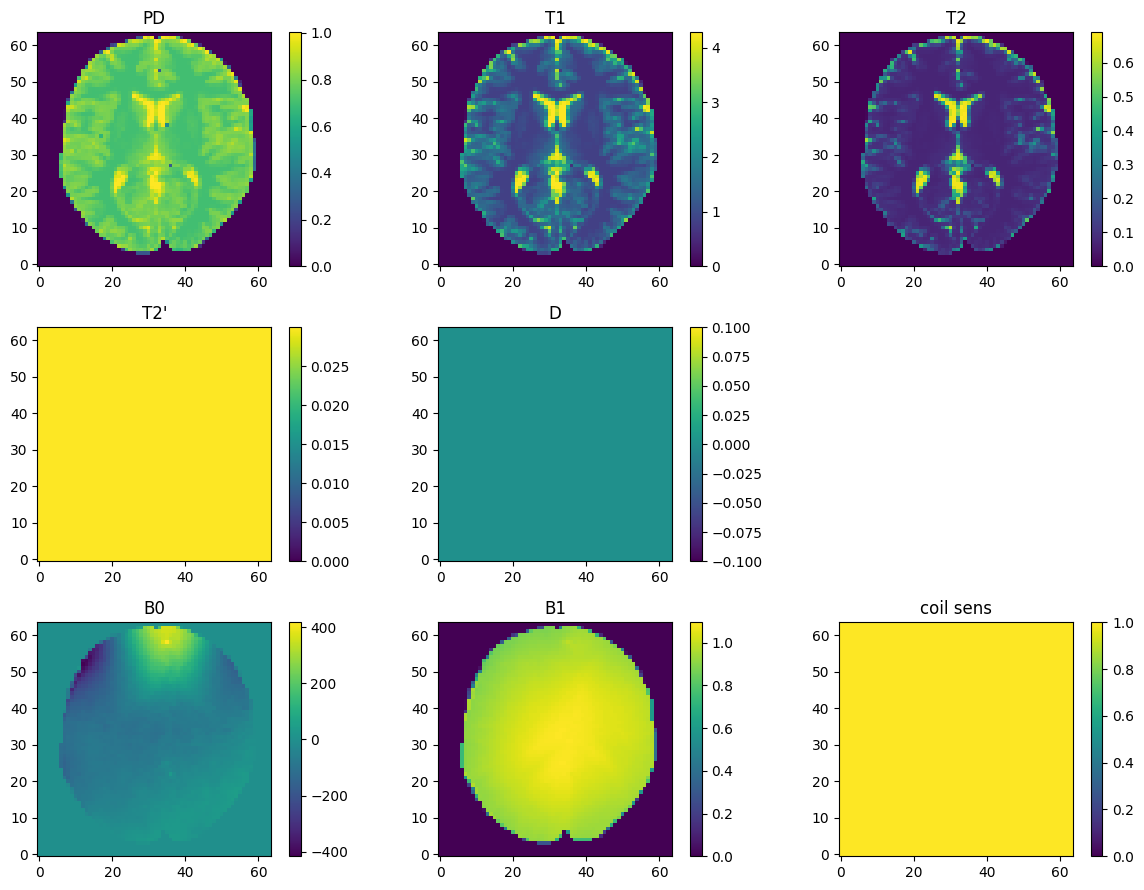

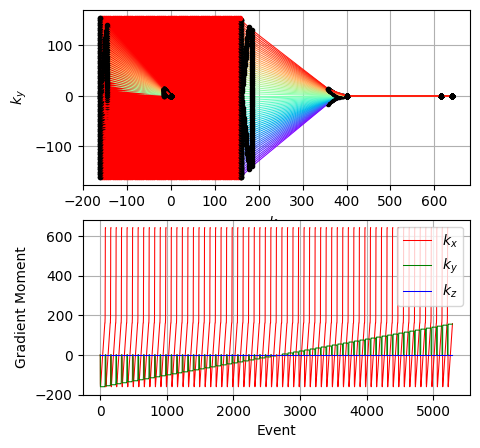

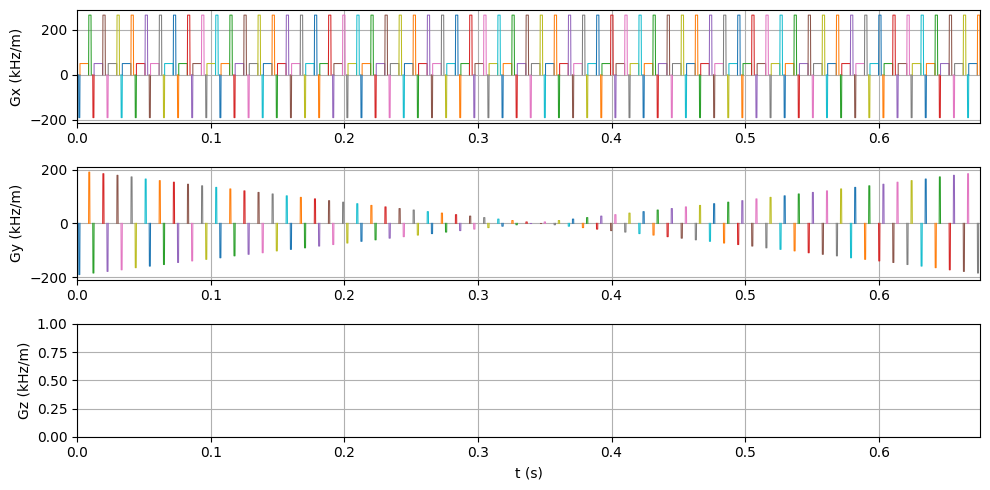

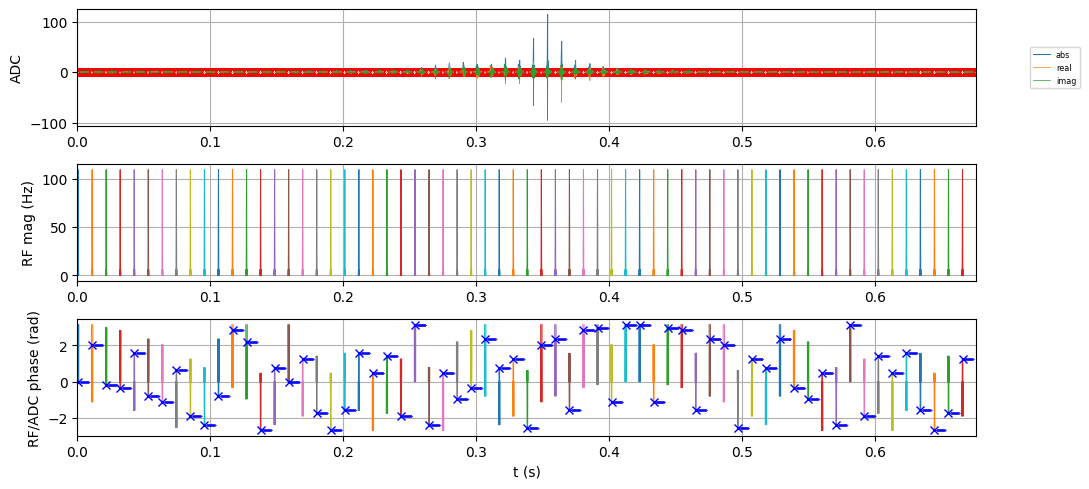

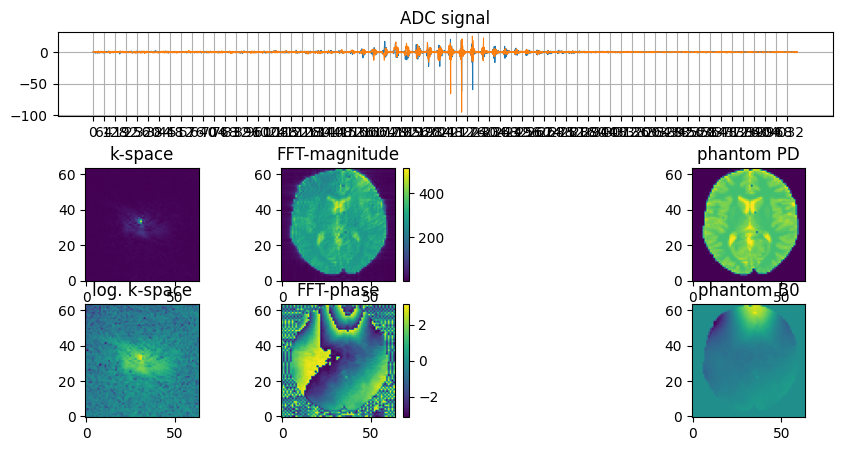

In [ ]:
# @title export, and manual phantom definition and reconstruction

# Prepare the sequence output for the scanner
seq.set_definition('FOV', [fov, fov, slice_thickness])
seq.set_definition('Name', 'gre')
seq.write(experiment_id + '.seq')

dB0_factor=10 # @param {type: "slider", min: 1, max: 10}

# %% S4: SETUP SPIN SYSTEM/object on which we can run the MR sequence external.seq from above
sz = [64, 64]
# (i) load a phantom object from file
obj_p = mr0.VoxelGridPhantom.load_mat('numerical_brain_cropped.mat')
obj_p = obj_p.interpolate(sz[0], sz[1], 1)
# Manipulate loaded data
obj_p.T2dash[:] = 30e-3
obj_p.D *= 0
obj_p.B0 *= dB0_factor    # alter the B0 inhomogeneity
# Store PD and B0 for comparison
PD = obj_p.PD
B0 = obj_p.B0
obj_p.plot()
# Convert Phantom into simulation data
obj_p = obj_p.build()


# %% S5:. SIMULATE  the external.seq file and add acquired signal to ADC plot
# Read in the sequence
seq0 = mr0.Sequence.import_file(experiment_id + '.seq')
seq0.plot_kspace_trajectory()
# Simulate the sequence
graph = mr0.compute_graph(seq0, obj_p, 200, 1e-3)
signal = mr0.execute_graph(graph, seq0, obj_p, print_progress=False)

# PLOT sequence with signal in the ADC subplot
seq.plot(plot_now=False)
mr0.util.insert_signal_plot(seq=seq, signal =signal.numpy())
plt.show()


# additional noise as simulation is perfect
signal += 1e-4 * np.random.randn(signal.shape[0], 2).view(np.complex128)


# %% S6: MR IMAGE RECON of signal ::: #####################################
fig = plt.figure()  # fig.clf()
plt.subplot(411)
plt.title('ADC signal')
kspace = torch.reshape((signal), (Nphase, Nread)).clone().t()
plt.plot(torch.real(signal), label='real')
plt.plot(torch.imag(signal), label='imag')

ipermvec = np.argsort(permvec)

kspace=kspace[:,ipermvec]
# this adds ticks at the correct position szread
major_ticks = np.arange(0, Nphase * Nread, Nread)
ax = plt.gca()
ax.set_xticks(major_ticks)
ax.grid()

# fftshift FFT fftshift
spectrum = torch.fft.fftshift(kspace)
space = torch.fft.fft2(spectrum)
space = torch.fft.ifftshift(space)

plt.subplot(345)
plt.title('k-space')
mr0.util.imshow(np.abs(kspace.numpy()))
plt.subplot(349)
plt.title('log. k-space')
mr0.util.imshow(np.log(np.abs(kspace.numpy())))

plt.subplot(346)
plt.title('FFT-magnitude')
mr0.util.imshow(np.abs(space.numpy()))
plt.colorbar()
plt.subplot(3, 4, 10)
plt.title('FFT-phase')
mr0.util.imshow(np.angle(space.numpy()), vmin=-np.pi, vmax=np.pi)
plt.colorbar()

# % compare with original phantom obj_p.PD
plt.subplot(348)
plt.title('phantom PD')
mr0.util.imshow(PD)
plt.subplot(3, 4, 12)
plt.title('phantom B0')
mr0.util.imshow(B0)

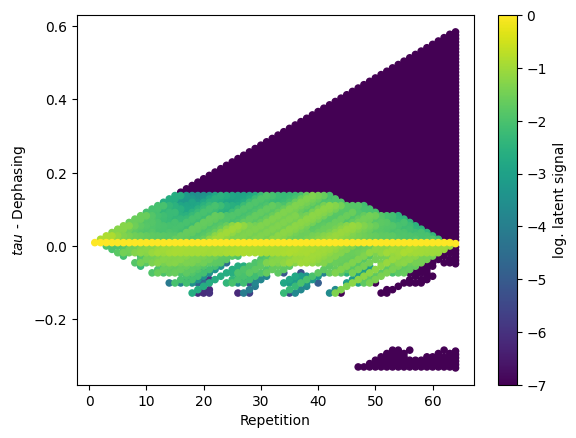

In [ ]:
#@title Plot the Phase Distribution Graph

plt.figure()
graph.plot(dephasing="tau", color="latent signal")
plt.show()